- Name: Meshalkin Artur
- Student-ID : 586811

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor, Pool, cv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from metrics import display_metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold

In [3]:
plt.rcParams.update({
    "figure.figsize": (12, 7),
    "font.size": 16,          
    "axes.titlesize": 20,   
    "axes.labelsize": 18,    
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 14,
    "legend.title_fontsize": 18,
    "figure.titlesize": 22
})

# 5.Modelltraining

In [4]:
df = pd.read_csv("new_cars.csv")
df.head()

,brand,color,power_kw,transmission_type,fuel_consumption_l_100km,offer_description,log_price,log_mileage,log_age,fuel_type_grouped,brand_transmission
0,alfa-romeo,red,148.0,Manual,10.9,2.0 V6 TB,7.170888,11.986055,3.443938,Petrol,alfa-romeo_Manual
1,alfa-romeo,black,110.0,Manual,9.5,2.0 16V Twin Spark L,8.497195,12.152150,3.451890,Petrol,alfa-romeo_Manual
2,alfa-romeo,red,132.0,Manual,7.2,"3.0i Super V6, absoluter Topzustand !",9.795401,11.473436,3.408504,Petrol,alfa-romeo_Manual
3,alfa-romeo,red,110.0,Manual,9.5,2.0 16V Twin Spark,8.974745,10.764435,3.427839,Petrol,alfa-romeo_Manual
4,alfa-romeo,red,110.0,Manual,8.8,Quadrifoglio,8.160804,12.345839,3.405853,Petrol,alfa-romeo_Manual


In [5]:
categorical_cols = df.select_dtypes(include='object').columns.tolist() 
categorical_cols.remove("offer_description")
numeric_cols = ["power_kw", "fuel_consumption_l_100km", "log_mileage", "log_age"]
df.head() 

,brand,color,power_kw,transmission_type,fuel_consumption_l_100km,offer_description,log_price,log_mileage,log_age,fuel_type_grouped,brand_transmission
0,alfa-romeo,red,148.0,Manual,10.9,2.0 V6 TB,7.170888,11.986055,3.443938,Petrol,alfa-romeo_Manual
1,alfa-romeo,black,110.0,Manual,9.5,2.0 16V Twin Spark L,8.497195,12.152150,3.451890,Petrol,alfa-romeo_Manual
2,alfa-romeo,red,132.0,Manual,7.2,"3.0i Super V6, absoluter Topzustand !",9.795401,11.473436,3.408504,Petrol,alfa-romeo_Manual
3,alfa-romeo,red,110.0,Manual,9.5,2.0 16V Twin Spark,8.974745,10.764435,3.427839,Petrol,alfa-romeo_Manual
4,alfa-romeo,red,110.0,Manual,8.8,Quadrifoglio,8.160804,12.345839,3.405853,Petrol,alfa-romeo_Manual


In [6]:
cat_features_idx = [len(numeric_cols) + i for i in range(len(categorical_cols))]
print("Categorical feature indices:", cat_features_idx)

Categorical feature indices: [4, 5, 6, 7, 8]


In [7]:
text_cols = ["offer_description"]

Als Model wurde  CatBoostRegressor ausgewählt.Der CatBoostRegressor ist ein Gradient-Boosting-Verfahren, das aus einer Vielzahl symmetrischer Entscheidungsbäume besteht, welche sequenziell trainiert werden, um die Fehler vorheriger Modelle zu korrigieren. Dieses Model kann  numerische, kategorische und text Features direkt verarbeiten. 

In [8]:
X = df.drop('log_price', axis=1)
y = df['log_price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", "passthrough", categorical_cols),
        ("text", "passthrough", text_cols), 
    ]
)
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['power_kw', 'fuel_consumption_l_100km',
                                  'log_mileage', 'log_age']),
                                ('cat', 'passthrough',
                                 ['brand', 'color', 'transmission_type',
                                  'fuel_type_grouped', 'brand_transmission']),
                                ('text', 'passthrough', ['offer_description'])])

In [9]:
cat_features_idx = [len(numeric_cols) + i for i in range(len(categorical_cols))]
text_features_idx = [9]


X_train_t = preprocessor.transform(X_train)
X_test_t = preprocessor.transform(X_test)


train_pool = Pool(
    X_train_t,
    label=y_train,
    cat_features=cat_features_idx,
    text_features=text_features_idx
)

test_pool = Pool(
    X_test_t,
    label=y_test,
    cat_features=cat_features_idx,
    text_features=text_features_idx
)

In [10]:
cat_model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.05,
        depth=6,
        eval_metric='R2',
        random_seed=42,
        verbose=200,
    )


cat_model.fit(
    train_pool,
    eval_set=test_pool,
    plot=True
)


y_train_pred = cat_model.predict(X_train_t)
y_test_pred = cat_model.predict(X_test_t)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0730350	test: 0.0731119	best: 0.0731119 (0)	total: 264ms	remaining: 8m 46s
200:	learn: 0.9071840	test: 0.9065746	best: 0.9065746 (200)	total: 32.3s	remaining: 4m 48s
400:	learn: 0.9148104	test: 0.9134293	best: 0.9134293 (400)	total: 1m	remaining: 4m 1s
600:	learn: 0.9182840	test: 0.9161370	best: 0.9161370 (600)	total: 1m 28s	remaining: 3m 24s
800:	learn: 0.9207149	test: 0.9178601	best: 0.9178601 (800)	total: 1m 54s	remaining: 2m 51s
1000:	learn: 0.9225126	test: 0.9189868	best: 0.9189868 (1000)	total: 2m 21s	remaining: 2m 21s
1200:	learn: 0.9240200	test: 0.9198960	best: 0.9198961 (1199)	total: 2m 47s	remaining: 1m 51s
1400:	learn: 0.9252784	test: 0.9205870	best: 0.9205870 (1400)	total: 3m 13s	remaining: 1m 22s
1600:	learn: 0.9264360	test: 0.9212235	best: 0.9212235 (1600)	total: 3m 40s	remaining: 54.9s
1800:	learn: 0.9273929	test: 0.9216766	best: 0.9216780 (1798)	total: 4m 9s	remaining: 27.5s
1999:	learn: 0.9282718	test: 0.9220758	best: 0.9220758 (1999)	total: 4m 36s	remainin

In [11]:
display_metrics(y_test,y_test_pred,y_train,y_train_pred)


Train MSE: 0.052 RMSE: 0.228, R²: 0.928, MAPE: 0.016
----------------------------------------------------------------------------------------------------
Test MSE:0.056 RMSE: 0.236, R²: 0.922, MAPE: 0.016
----------------------------------------------------------------------------------------------------


Das Modell erzielt sowohl auf dem Trainings- als auch auf dem Testdatensatz sehr gute Ergebnisse.
Mit einem R² von 0,928 im Training und 0,922 im Test erklärt das Modell über 92 % der Varianz der logarithmierten Zielvariable.
Die geringen Unterschiede zwischen Trainings- und Testergebnissen deuten auf eine hohe Generalisierungsfähigkeit und kein Overfitting hin.
Die niedrigen Fehlerwerte (RMSE ≈ 0,23; MAPE ≈ 1,6 %) bestätigen die hohe Vorhersagegenauigkeit des Modells.

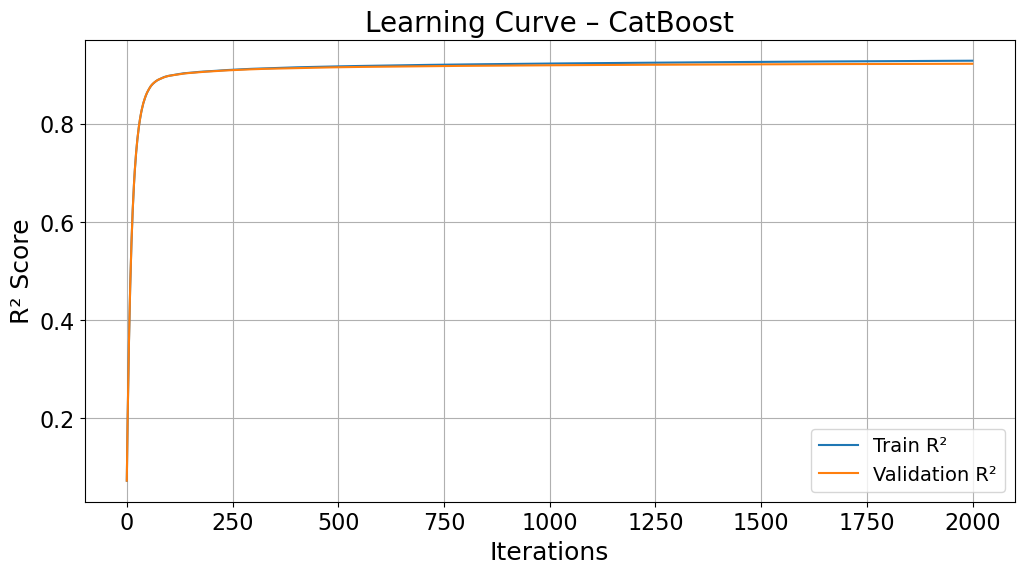

In [12]:
evals = cat_model.get_evals_result()

train_r2 = evals['learn']['R2']
test_r2 = evals['validation']['R2']

plt.figure(figsize=(12,6))
plt.plot(train_r2, label='Train R²')
plt.plot(test_r2, label='Validation R²')
plt.xlabel("Iterations")
plt.ylabel("R² Score")
plt.title("Learning Curve – CatBoost")
plt.legend()
plt.grid(True)
plt.show()


Die Lernkurven zeigen einen schnellen Anstieg der Modellleistung in den ersten Iterationen.
Trainings- und Validierungswerte verlaufen nahezu deckungsgleich, was auf eine sehr gute Generalisierungsfähigkeit und kein Overfitting hinweist.
Ab etwa 400 Iterationen konvergiert das Modell, sodass zusätzliche Iterationen nur noch geringe Leistungsgewinne bringen.

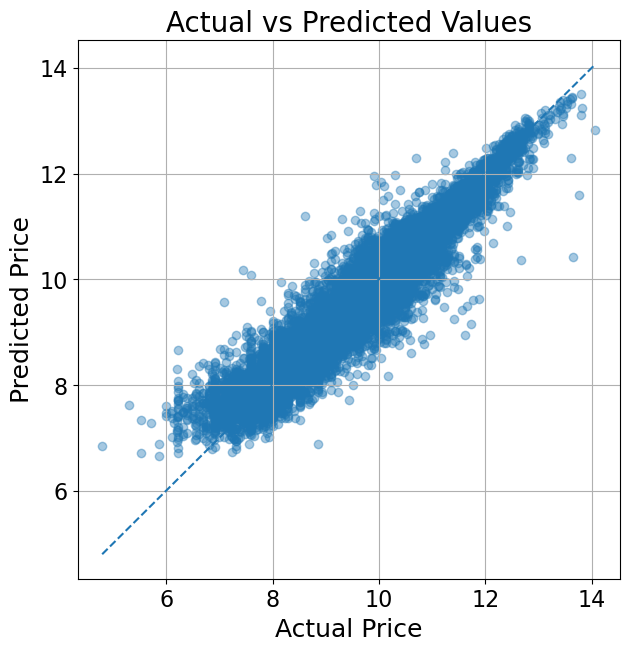

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    '--'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.show()


Der Vergleich zwischen tatsächlichen und vorhergesagten Werten zeigt eine starke Übereinstimmung entlang der idealen Diagonalen.
Die enge Punktwolke weist auf eine hohe Vorhersagegenauigkeit hin.
Leichte Abweichungen treten überwiegend im unteren Preissegment auf, was auf eine höhere Varianz günstiger Fahrzeuge zurückzuführen ist und keinen systematischen Modellfehler darstellt

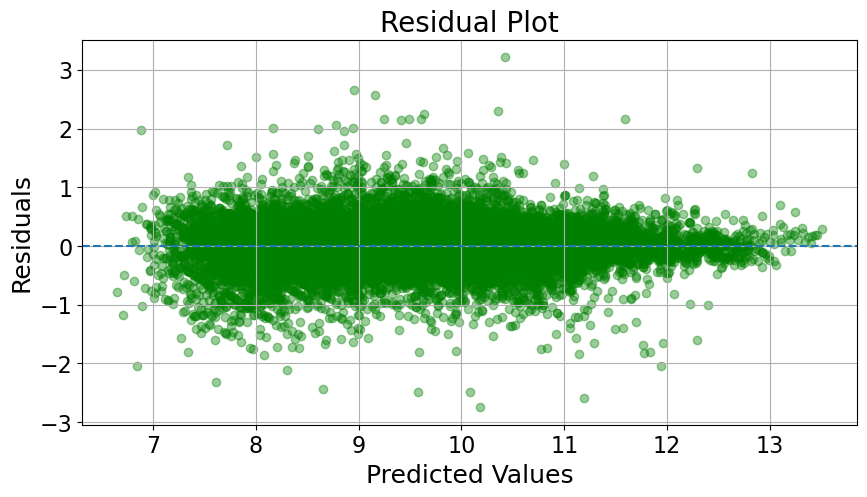

In [14]:
residuals = y_test - y_test_pred

plt.figure(figsize=(10,5))
plt.scatter(y_test_pred, residuals, alpha=0.4,c="green")
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


Der Residualplot zeigt kein systematisches Muster, und die Residuen sind um den Wert Null zentriert, was auf ein unverzerrtes Modell hinweist.
Eine leichte Heteroskedastizität ist erkennbar, wobei die Varianz der Fehler bei niedrigeren vorhergesagten Preisen größer ist.
Dieses Verhalten ist aufgrund der höheren Variabilität günstiger Fahrzeuge zu erwarten und stellt keine Fehl­spezifikation des Modells dar

# 6.Modellevaluierung

In [16]:
from catboost import Pool, cv

cv_dataset = Pool(
    data=X_train_t,
    label=y_train,
    cat_features=cat_features_idx,
    text_features=text_features_idx
)

params = {
    "iterations": 2000,
    "depth": 6,
    "loss_function": "RMSE",
    "eval_metric": "R2",
    "random_seed": 42,
    "verbose": 1000
}

scores = cv(
    pool=cv_dataset,
    params=params,
    fold_count=3,
    shuffle=True,
    partition_random_seed=42
)

scores.tail()


Training on fold [0/3]
0:	learn: -123.8928610	test: -124.1188552	best: -124.1188552 (0)	total: 114ms	remaining: 3m 48s
1000:	learn: 0.9181511	test: 0.9131437	best: 0.9131437 (1000)	total: 2m 39s	remaining: 2m 39s
1999:	learn: 0.9246734	test: 0.9169959	best: 0.9169959 (1999)	total: 4m 31s	remaining: 0us

bestTest = 0.9169959269
bestIteration = 1999

Training on fold [1/3]
0:	learn: -123.6367846	test: -124.6368146	best: -124.6368146 (0)	total: 133ms	remaining: 4m 25s
1000:	learn: 0.9179670	test: 0.9133672	best: 0.9133672 (1000)	total: 2m 4s	remaining: 2m 4s
1999:	learn: 0.9244236	test: 0.9173094	best: 0.9173094 (1999)	total: 3m 47s	remaining: 0us

bestTest = 0.9173093813
bestIteration = 1999

Training on fold [2/3]
0:	learn: -124.3785571	test: -123.1645612	best: -123.1645612 (0)	total: 147ms	remaining: 4m 54s
1000:	learn: 0.9168463	test: 0.9163632	best: 0.9163632 (1000)	total: 1m 51s	remaining: 1m 51s
1999:	learn: 0.9235251	test: 0.9200429	best: 0.9200429 (1999)	total: 3m 45s	remaining: 

,iterations,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
1995,1995,0.918102,0.001682,0.924185,0.000601,0.244109,0.001813,0.234881,0.000630
1996,1996,0.918104,0.001682,0.924189,0.000600,0.244105,0.001814,0.234875,0.000629
1997,1997,0.918108,0.001681,0.924195,0.000601,0.244101,0.001812,0.234866,0.000631
1998,1998,0.918111,0.001678,0.924201,0.000603,0.244096,0.001809,0.234858,0.000635
1999,1999,0.918116,0.001676,0.924207,0.000604,0.244088,0.001804,0.234847,0.000637


Das Modell zeigt eine sehr hohe und stabile Vorhersagegüte.
Die geringen Unterschiede zwischen Trainings- und Testergebnissen sprechen gegen Overfitting.
Sowohl R² als auch RMSE weisen auf eine gute Generalisierungsfähigkeit hin.

## Verbesserungsmöglichkeiten

- Umgang mit elektro Autos
- Webscraper für aktuelle Daten bauen
- Term Frequency – Inverse Document Frequency anstatt Bag of Words
